In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Suppress annoying warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Data Cleaning

Here we map the names of the animal classes in ```class.csv``` to their corresponding ids in ```zoo.csv```.

In [4]:
animals = pd.read_csv('../data/zoo.csv')
# animals.drop(['animal_name'], axis=1, inplace=True)

# animal_names = pd.read_csv('../data/zoo.csv').animal_name


classes = pd.read_csv('../data/class.csv')
classes.columns = [col.lower() for col in classes.columns]
classes = classes[['class_number', 'class_type']].rename({'class_type':'class_name', 'class_number':'class_type'}, axis=1)

animals = animals.merge(classes)

animal_names = animals[['animal_name', 'class_name']]

## Model Preparation

In [5]:
targets = animals.class_name.unique()
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name', 'legs'], axis=1).columns

dummy_legs = pd.get_dummies(animals.legs, drop_first=True)
dummy_legs.columns = [str(col) + '_legs'  for col in dummy_legs.columns]

X = animals[features].join(dummy_legs)
y = animals.class_type.as_matrix()

## Define qualitative colors for plotting each class

Trying to think of some more intuitive colors for each of the classes....

In [6]:
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

cmap = cm.get_cmap('Accent', 7)
colors = [rgb2hex(cmap(i)[:3]) for i in range(7)]

# Is our data linearly separable?

## Linear Discriminant Analysis + Computational Geometry
The model will basically draw lines through the outer points of each class in lower-dimensional space to create the smallest possible polygon that encapsulates every point in the class. If any of the shapes overlap, the data is not linearly separable based on the x- and y-components. To detect overlap, we use what's called the convex hull algorithm. The picture below demonstrates this concept:


![img](../img/linear_separability_demonstration.jpg)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import pylab as pl

In [8]:
def plot_decomp_samples(X, y, est='LDA'):
    est = est.lower()
    if est == 'lda':
        X_r = LDA(n_components=2).fit_transform(X, y)
    elif est == 'pca':
        X_r = PCA(n_components=2).fit_transform(X, y)
    else:
        raise ValueError('est must be "pca" or "lda"')
    
    plt.clf()
    plt.figure(figsize = (12, 8))
    targets = classes.class_name
    plt.title(est.upper() + ' Projection of Animal Features')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')

    for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
        bucket = X_r[y == i, :]
        try:
            hull = ConvexHull(bucket) 
            for j in hull.simplices:
                plt.plot(bucket[j,0], bucket[j,1], color)
        except:
            hull = None

        coords = list(zip(bucket[:,0], bucket[:,1], animals[animals.class_type == i].index))
        plt.scatter(bucket[:, 0], bucket[:, 1], color=color, alpha=.8, lw=.5, label=target)
#         for x1,x2,ind in coords:
#             pl.text(x1, x2, str(ind), color='black', fontsize=12)

    plt.legend(prop={'size': 12})
    plt.show()

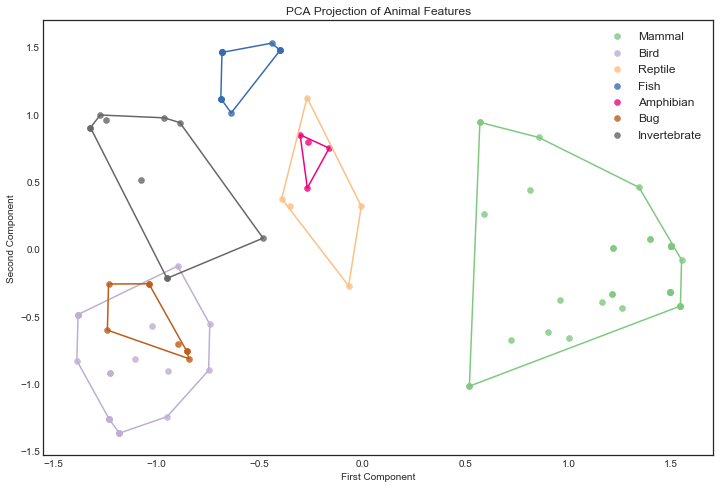

In [9]:
sns.set_style('white')
plot_decomp_samples(X.drop('animal_name', 1), y, 'pca')

Although the LDA visualization looks better, PCA tends to perform better when the number of classes in each sample is small, which is the case for us. For this reason we will consider a PCA-based classification.

### Single Layer Perceptron

If our data is linearly separable, then we should be able to run it through a convergent single layer perceptron. A single layer perceptron will only converge if the input vectors are linearly separable. In this state, all input vectors would be classified correctly indicating linear separability. We will apply it on the entire dataset instead of splitting into train/test since our intent is to test for linear separability among the classes and not to build a model for future predictions. We don't have to do any feature scaling because all of our inputs are binary.

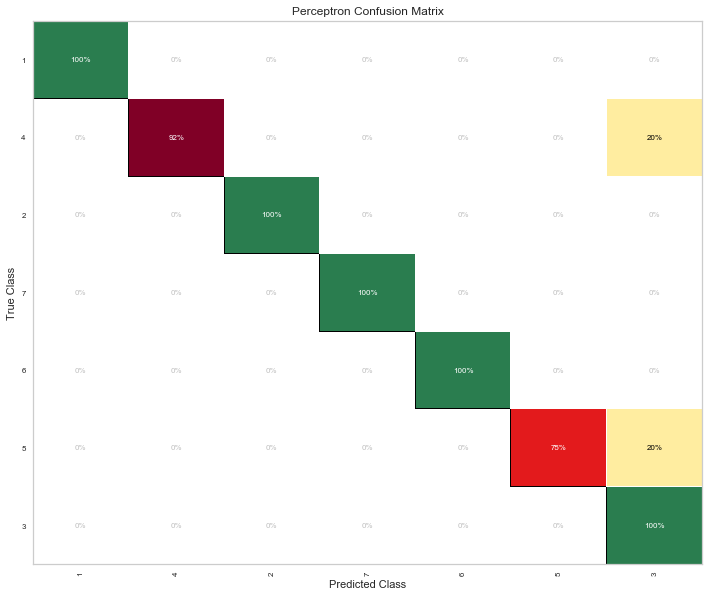

In [10]:
from sklearn.linear_model import Perceptron
from yellowbrick.classifier import ConfusionMatrix
perc = Perceptron(random_state=42)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(perc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', axis=1), y).score(X.drop('animal_name', axis=1), y)
fig = cm.poof()

The confusion matrix shows us that our data is not linearly separable as it stands. We mistook a fish for a reptile and a reptile for an amphibian. The next step will be to try projecting our features into a higher dimensional space in which the data may be linearly separable, ie. run the data through a support vector machine.

## PCA Classifier

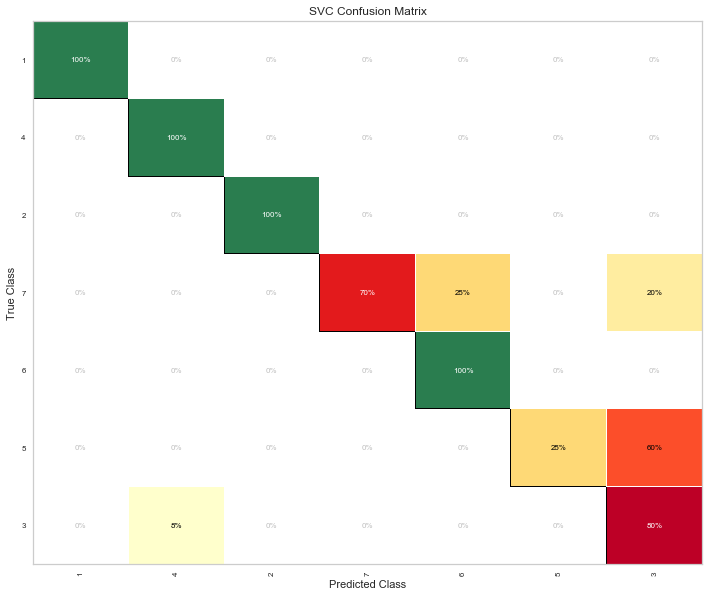

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

pca_svc = make_pipeline(PCA(n_components=3), SVC(kernel='linear', random_state=42))

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(pca_svc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', axis=1), y).score(X.drop('animal_name', axis=1), y)
fig = cm.poof()

In [12]:
pca_svc.steps[0][1].explained_variance_ratio_

array([ 0.35056485,  0.18760977,  0.13405563])

In [13]:
bad = set()
for i,actual,pred in zip(X.index.values, y, pca_svc.predict(X.drop('animal_name', axis=1))):
    if actual != pred:
        bad.add(i)

The PCA approach doesn't look great. Let's try a regular support vector machine without any dimension reduction.

# Support Vector Machine

In [14]:
svc = SVC(kernel='linear', class_weight='balanced')

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', axis=1)[important_features], y).score(X.drop('animal_name', axis=1)[important_featurest_features], y)
fig = cm.poof()

NameError: name 'important_features' is not defined

Sweet baby jesus we've done it. We have linear separability!

# SVM Hyperparameter Tuning

Now that we know the dataset is linearly separable, let's cross-validate the model to find the optimal hyperparameters. Although we performed perfectly on all of the data with a linear kernel, other kernels might generalize better, so the hyperparameters of interest will be **C**, **gamma**, and **kernel**.

In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop('animal_name', 1), y, stratify=y) 

Cs = [.001, .01, .1, 1, 10]
gammas = [.001, .01, .1, 1]
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

param_grid = {'C':Cs, 'gamma':gammas, 'kernel':kernels}

n_folds = n_classes # Number of folds must be less than number of obs in smallest class
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

C:\Users\samba\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\samba\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\samba\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=7.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=7, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [16]:
grid_search.best_params_

{'C': 0.01, 'gamma': 1, 'kernel': 'poly'}

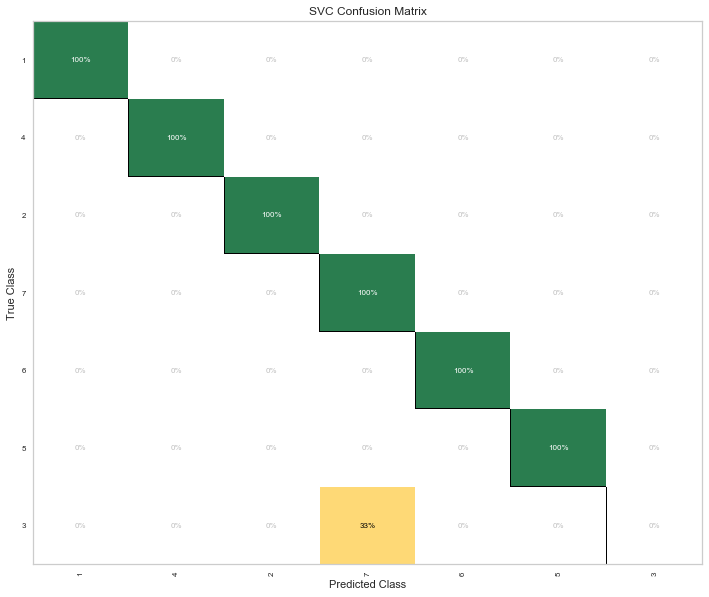

In [17]:
svc = SVC(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

Alrighty then! It looks like my work here is done...we predicted test set perfectly. Based on the cross-validation, our optimal hyperparameters were a C of .1, gamma of 1, and polynomial kernel.

# Naive Bayes Classifier

In [18]:
from sklearn.naive_bayes import BernoulliNB

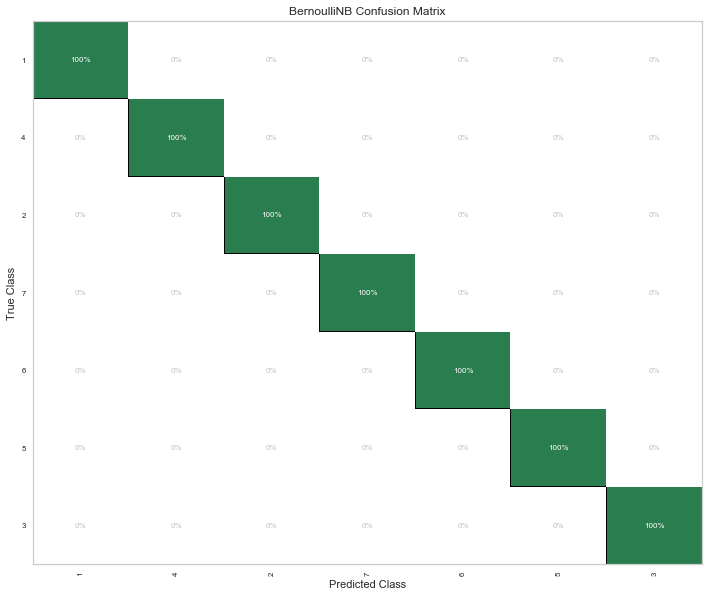

In [19]:
bnb = BernoulliNB()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(bnb, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

In [20]:
alphas = [.00001, .0001, .001, .01, .1, 1, 10]
fit_priors = [True, False]
param_grid = {'alpha': alphas, 'fit_prior': fit_priors}

n_folds = 3
grid_search = GridSearchCV(BernoulliNB(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [21]:
grid_search.best_params_

{'alpha': 1e-05, 'fit_prior': True}

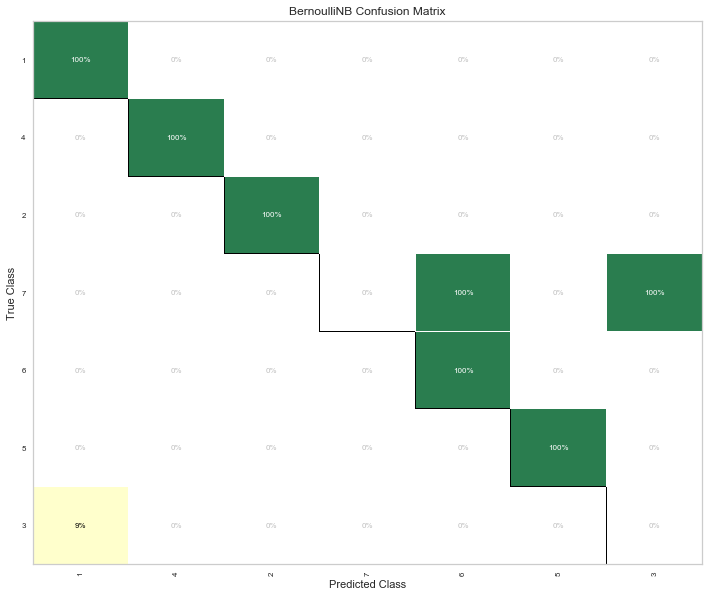

In [22]:
bnb = BernoulliNB(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(bnb, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

# K Nearest Neighbors Classifier

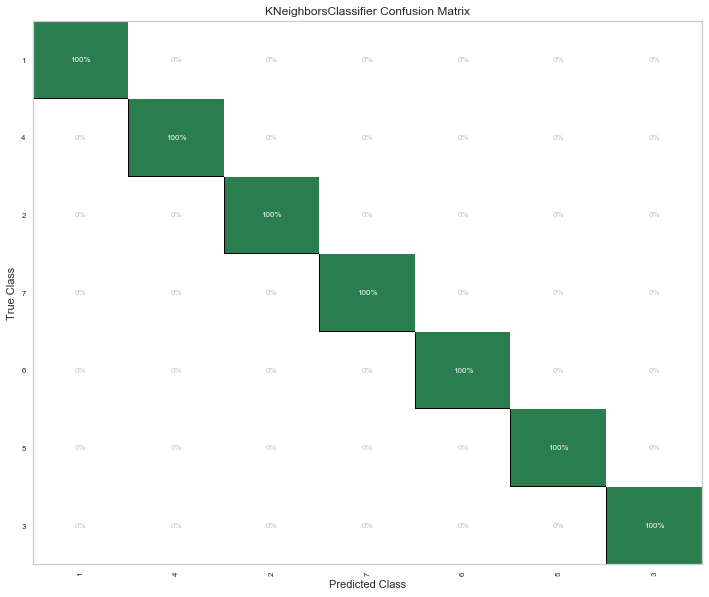

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(1)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

# K Nearest Neighbors Cross-validation

In [24]:
n_neighbors = np.arange(1, 6)
metrics = ['euclidean', 'minkowski', 'jaccard', 'dice']
param_grid = {'n_neighbors': n_neighbors, 'metric':metrics}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([1, 2, 3, 4, 5]), 'metric': ['euclidean', 'minkowski', 'jaccard', 'dice']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

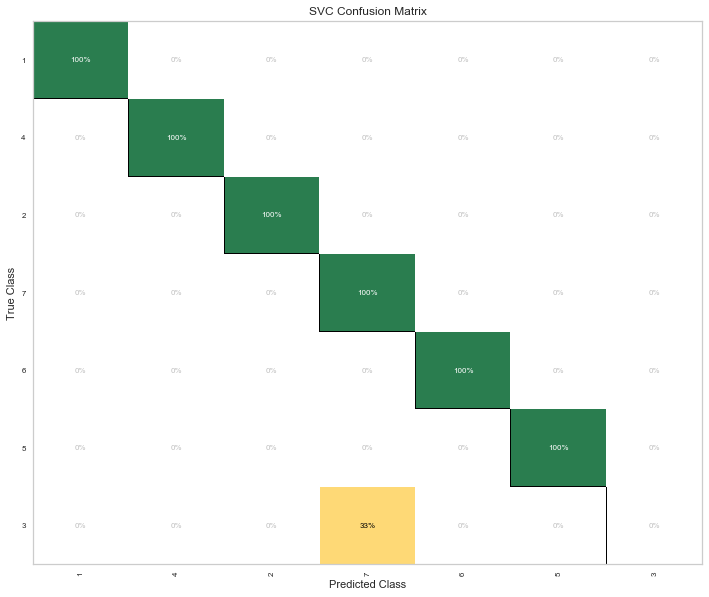

In [25]:
knc = KNeighborsClassifier(**grid_search.best_params_)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X_train, y_train).score(X_test, y_test)
fig = cm.poof()

# Gradient Boosting Machine

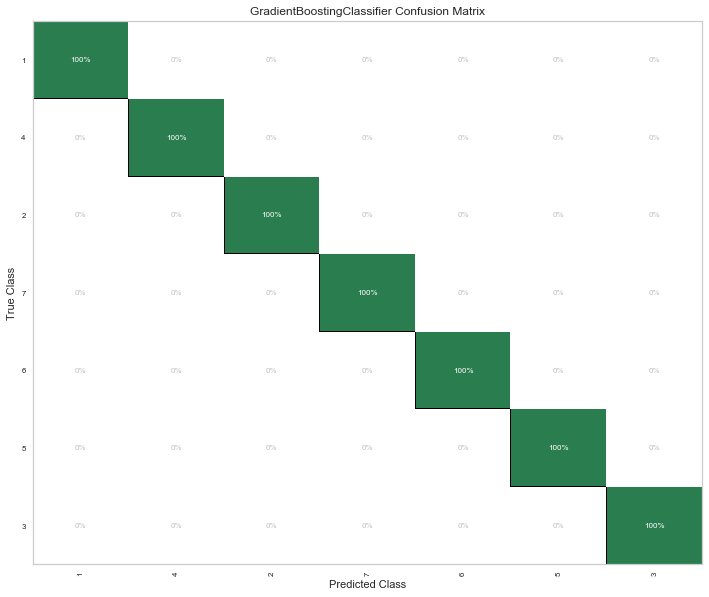

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

knc = GradientBoostingClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(knc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

In [27]:
# n_estimators = np.arange(20,81,10)
# max_depths = np.arange(5,16,2)
# min_samples_splits = np.arange(200,1001,200)
# max_features = np.arange(7,20,2)
# param_grid = {'n_estimators': n_estimators, 
#               'max_depth': max_depths, 
#               'min_samples_split': min_samples_splits, 
#               'max_features': max_features}

# grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=n_folds)
# grid_search.fit(X_train, y_train)

In [28]:
min_samples_splits = np.arange(20,31,5)
max_features = np.arange(16,21,1)
param_grid = {'min_samples_split': min_samples_splits, 
              'max_features': max_features}

grid_search = GridSearchCV(GradientBoostingClassifier(n_estimators=20, max_depth=5), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([20, 25, 30]), 'max_features': array([16, 17, 18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

# Multilayer Perceptron

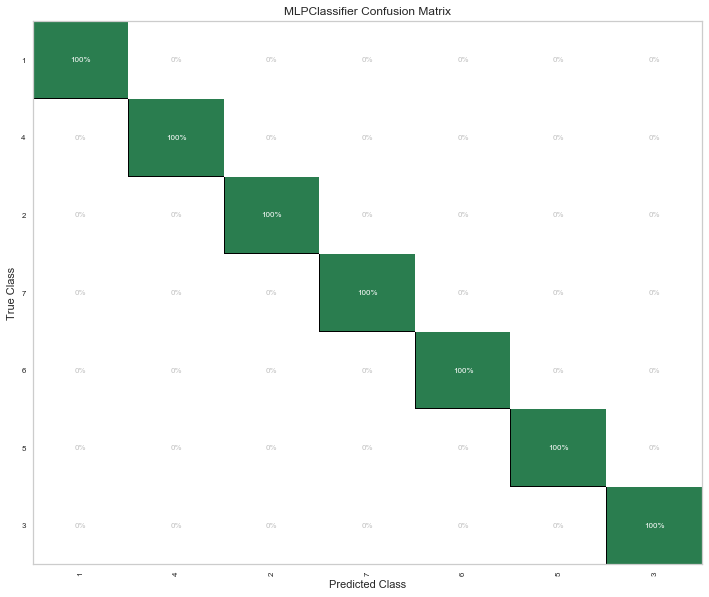

In [29]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(mlp, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

### TODO: Tune MLP Hyperparamters

In [30]:
param_grid = {}

grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

# Random Forest

Here we try a random forest, but in practice decision tree based apporaches tend not to perform well on small datasets (they overfit).

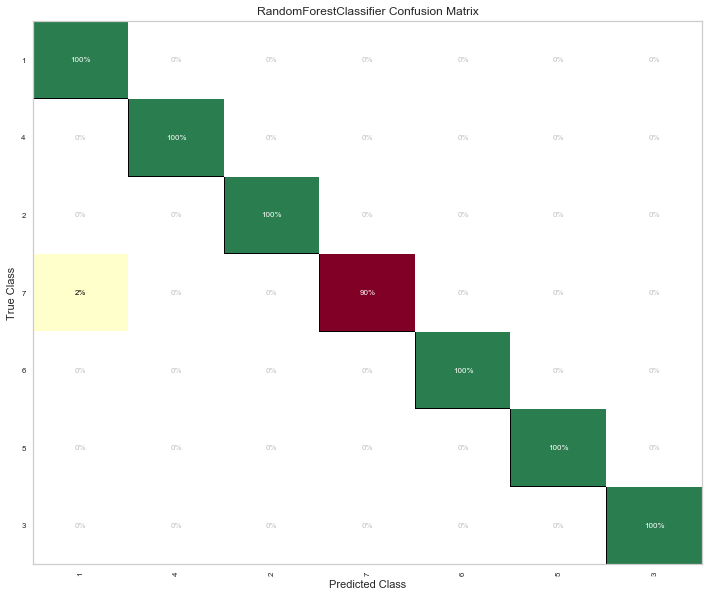

In [31]:
from sklearn.ensemble import RandomForestClassifier

mlp = RandomForestClassifier()

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(mlp, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

### TODO: Tune Random Forest Hyperparameters

In [32]:
param_grid = {}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=n_folds)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

# Testing

## GridSearch Cross-validation

Let's see if we just got lucky with our cross-validation by simulating a variety of random seeds for splitting the data into test and train.

In [33]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def test_model(seed, X, y, est):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)
    if est == 'poly_svc':
        params = {'C': .01, 'gamma': 1, 'kernel': 'poly', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'linear_svc':
        params = {'C': .1, 'kernel': 'linear', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'rbf_svc':
        params = {'C': .1, 'gamma': 1, 'kernel': 'rbf', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'bnb':
        params = {'alpha': 1, 'fit_prior': True}
        model = BernoulliNB(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'knc':
        params = {'n_neighbors': 3, 'metric': 'euclidean'}
        model = KNeighborsClassifier(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'gbm':
        params = {'n_estimators': 20, 'max_depth': 5, 'max_features': 19, 'min_samples_split': 15}
        model = GradientBoostingClassifier(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'mlp':
        model = MLPClassifier().fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'rf':
        model = RandomForestClassifier().fit(X_train.drop(['animal_name'], axis=1), y_train)
    else:
        raise ValueError('est parameter must be svc, knc, gbm, or mlp')
        
    for animal_name,actual,pred in zip(X_train.animal_name, y_test, model.predict(X_test.drop(['animal_name'], axis=1))):
        if actual != pred:
            bad.append((est, animal_name))
    
    y_preds = model.predict(X_test.drop(['animal_name'], axis=1))
    accuracy = model.score(X_test.drop(['animal_name'], axis=1), y_test)
    f1 = f1_score(y_test, y_preds, average='weighted')
    
    return accuracy, f1, pd.DataFrame(list(precision_recall_fscore_support(y_test, y_preds))).transpose().as_matrix()

In [34]:
def simulate_model(n_simulations, X, y, est):
    scores = []
    f1_scores = []
    accuracies = []
    for seed in range(n_simulations):
#         if seed % 100 == 0: print(seed)
        accuracy, f1, scoring = test_model(seed, X, y, est.lower())
        scores.append(scoring)
        accuracies.append(accuracy)
        f1_scores.append(f1)
#     print('The average accuracy for ' + est.upper() + ' across {} simulations was {:.2%}'.format(n_simulations, np.mean(scores)))
    return np.mean(accuracies), np.mean(f1_scores), scores

In [35]:
estimators = ['poly_svc', 'linear_svc', 'knc']

In [586]:
bad = []
n_simulations = 1000
scores = []
accuracies = []
f1_scores = []
for est in estimators:
    accuracy, f1, scoring = simulate_model(n_simulations, X, y, est)
    scores.append(scoring)
    accuracies.append((est, accuracy))
    f1_scores.append((est, f1))

In [587]:
accuracies

[('poly_svc', 0.96473076923076928),
 ('linear_svc', 0.95950000000000013),
 ('knc', 0.95069230769230773)]

In [588]:
f1_scores

[('poly_svc', 0.95490723443223458),
 ('linear_svc', 0.95551950549450559),
 ('knc', 0.94305937395937389)]

In [547]:
average_scores = []
for score,est in list(zip(scores,estimators)):
    total = score[0]
    for i in range(1, n_simulations):
        total = total + score[i]
    df = pd.DataFrame(total / n_simulations)
    df.columns = ['precision', 'recall', 'fscore', 'support']
    df['model'] = est
    average_scores.append(classes.join(df).drop('class_type', 1).set_index('class_name'))

In [548]:
average_scores = pd.concat(average_scores).reset_index()

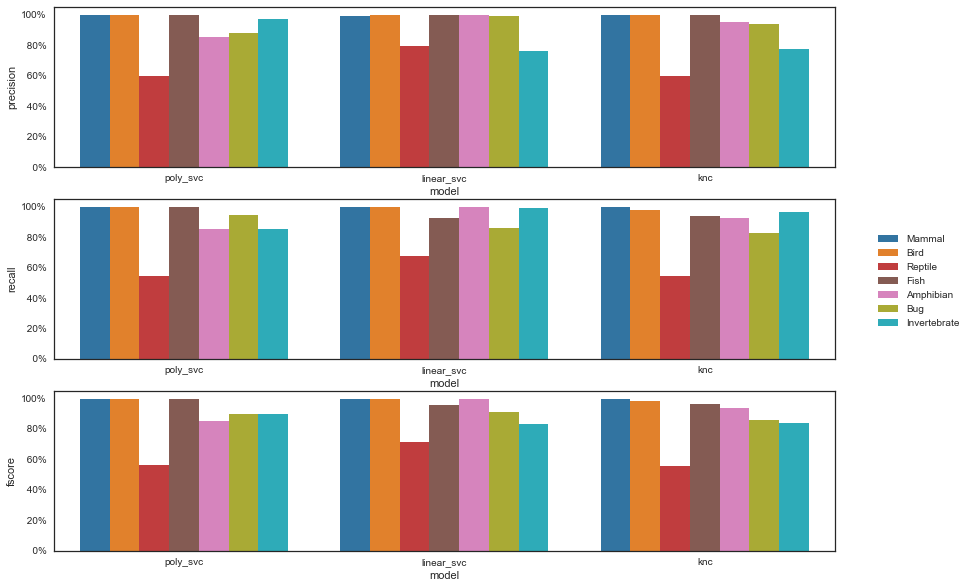

In [549]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
plt.figure()
sns.barplot(x='model', y='precision', hue='class_name', data=average_scores, ax=ax1, palette=palette)
# ax1.set_ylim(0.5, 1)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax1.legend_.remove()

sns.barplot(x='model', y='recall', hue='class_name', data=average_scores, ax=ax2, palette=palette)
# ax2.set_ylim(0.5, 1)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax2.legend(bbox_to_anchor=(1.05, .8), loc=2, borderaxespad=0.)

sns.barplot(x='model', y='fscore', hue='class_name', data=average_scores, ax=ax3, palette=palette)
# ax3.set_ylim(0.5, 1)
vals = ax3.get_yticks()
ax3.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax3.legend_.remove()

In [550]:
average_scores

,class_name,precision,recall,fscore,support,model
0,Mammal,0.999236,1.000000,0.999579,10.9916,poly_svc
1,Bird,1.000000,1.000000,1.000000,5.0000,poly_svc
2,Reptile,0.598200,0.546745,0.563733,0.7527,poly_svc
3,Fish,1.000000,0.999600,0.999750,3.0020,poly_svc
4,Amphibian,0.851900,0.851900,0.851900,0.8519,poly_svc
5,Bug,0.882250,0.944900,0.896334,1.8463,poly_svc
6,Invertebrate,0.973900,0.850392,0.895140,3.5555,poly_svc
7,Mammal,0.989845,1.000000,0.994475,10.8883,linear_svc
8,Bird,1.000000,1.000000,1.000000,5.0000,linear_svc
9,Reptile,0.797700,0.676950,0.717200,1.0832,linear_svc


In [551]:
fscores = average_scores[['model', 'class_name', 'fscore']]

In [552]:
fscores = fscores.pivot(index='model', columns='class_name', values='fscore').reset_index()

In [553]:
fscores.model = ['Support Vector Machine (Polynomial Kernel)', 'Support Vector Machine (Linear Kernel)', 'K Neighbors Classifier']

Text(0.5,1.1,'Model F-scores by Class')

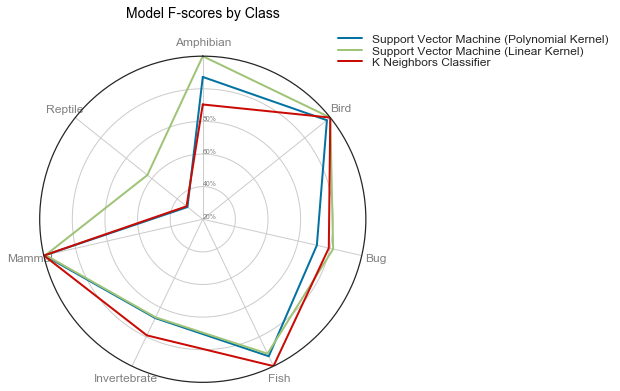

In [554]:
from math import pi


# number of variable
categories = list(fscores)[1:]
N = len(categories)

# Angle calcs
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Value calcs
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='polar')

plt.xticks(angles[:-1], categories, color='grey', size=12)

# Put the first axis on top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([.50, .60, .70, .80, .90], ["20%","40%","60%","80%"], color="grey", size=7)
plt.ylim(0.5,1)

for model,color in list(zip(precisions.model, ['r', 'b', 'g'])):
    values = fscores[fscores.model == model].drop('model', 1).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid')

ax.legend(fscores.model.values, loc=(0.9, .95), labelspacing=0.1, fontsize='medium')
# # Add a title
plt.title('Model F-scores by Class', size=14, color='black', y=1.1)


| Model  | Accuracy  |
|:-------|----------:|
| SVC    | 97.43%    |
| BNB    | 95.33%    |
| KNC    | 95.10%    |
| GBM    | 96.43%    |
| MLP    | 96.47%    |
| RF     | 96.58%    |

In [42]:
bad_df = pd.DataFrame(bad, columns=['model', 'animal_name'])
bad_df = bad_df.merge(pd.DataFrame(animal_names), how='left')

In [43]:
animal_counts = pd.DataFrame(bad_df.groupby('model').animal_name.value_counts())
animal_counts.columns = ['cnt']
animal_counts = animal_counts.reset_index()
animal_counts = animal_counts.merge(animal_names)

animal_counts = animal_counts.sort_values(['model', 'cnt'], ascending=False)

,model,animal_name,cnt,class_name
11,svc,dove,17,Bird
23,svc,mongoose,15,Mammal
243,svc,ostrich,12,Bird
283,svc,lion,12,Mammal
59,svc,bass,11,Fish
95,svc,girl,11,Mammal
15,svc,hamster,10,Mammal
19,svc,flea,10,Bug
39,svc,oryx,10,Mammal
63,svc,pike,10,Fish


In [44]:
class_counts = pd.DataFrame(animal_names.groupby(['class_name']).count()).reset_index()
animal_counts = animal_counts.merge(class_counts, on='class_name', how='left', suffixes=('_animal', '_class'))

In [46]:
animal_counts.groupby('animal_name_animal').cnt.sum().sort_values(ascending=False).head(5)

animal_name_animal
dove        71
mongoose    65
flea        60
gnat        60
oryx        57
Name: cnt, dtype: int64

## Jackknife Cross-Validation

Since our dataset is so small, we will try leave-one-out cross-validation. This can be thought of as k-fold cross-validation where k=n.

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

In [39]:
wrong_dfs = []

In [154]:
def jackknife_cv(X, y, est='SVC', ts=False):
    est = est.lower()
    if est == 'poly_svc':
        params = {'C': .01, 'gamma': 1, 'kernel': 'poly', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'linear_svc':
        params = {'C': .1, 'kernel': 'linear', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'rbf_svc':
        params = {'C': .1, 'gamma': 1, 'kernel': 'rbf', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'bnb':
        params = {'alpha': 1, 'fit_prior': True}
        model = BernoulliNB(**params)
    elif est == 'knc':
        params = {'n_neighbors': 3, 'metric': 'euclidean'}
        model = KNeighborsClassifier(**params)
    elif est == 'gbm':
        params = {'n_estimators': 20, 'max_depth': 5, 'max_features': 19, 'min_samples_split': 15}
        model = GradientBoostingClassifier(**params)
    elif est == 'mlp':
        model = MLPClassifier()
    elif est == 'rf':
        model = RandomForestClassifier()
    else:
        raise ValueError('est parameter must be svc, knc, gbm, or mlp')
    
    scores = []
    wrong = []
    for train_index, test_index in LeaveOneOut().split(X.drop('animal_name', 1)):
        X_train, X_test = X.drop('animal_name', 1).loc[train_index], X.drop('animal_name', 1).loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        if not ts:
            if y_test[0] != model.predict(X_test)[0]:
                wrong.append(test_index[0])
    
    return scores, wrong

In [155]:
wrong_dfs = []
for est in estimators:
    scores, wrong = jackknife_cv(X, y, est)
    print('The average accuracy for ' + est.upper() + ' with jackknife cross-validation was {:.2%}.'.format(np.mean(scores)))
    wrong_dfs.append((est, animal_names.iloc[wrong]))

The average accuracy for SVC with jackknife cross-validation was 97.03%.


## Which samples are difficult to predict?

In [47]:
for est,df in wrong_dfs:
    print(est)
    print(df)

svc
   animal_name class_name
94        newt  Amphibian
97    seasnake    Reptile
99    tortoise    Reptile
bnb
   animal_name    class_name
79    scorpion  Invertebrate
81        slug  Invertebrate
83        worm  Invertebrate
94        newt     Amphibian
97    seasnake       Reptile
99    tortoise       Reptile
knc
   animal_name    class_name
81        slug  Invertebrate
83        worm  Invertebrate
84        flea           Bug
90     termite           Bug
97    seasnake       Reptile
gbm
   animal_name    class_name
77     lobster  Invertebrate
79    scorpion  Invertebrate
97    seasnake       Reptile


In [48]:
dfs = [df.reset_index() for _, df in wrong_dfs]

In [49]:
wrong = pd.concat(dfs)

### Incorrect Predictions by Class

In [50]:
wrong.groupby('class_name').apply(lambda x: x.shape[0])

class_name
Amphibian       2
Bug             2
Invertebrate    7
Reptile         6
dtype: int64

### Incorrect Predictions by Animal

In [51]:
wrong.groupby('animal_name').apply(lambda x: x.shape[0])

animal_name
flea        1
lobster     1
newt        2
scorpion    2
seasnake    4
slug        2
termite     1
tortoise    2
worm        2
dtype: int64

# Feature Selection

Let's see if we can remove some redundant features and make our model more generalizable. 

In [52]:
selector = RFECV(svc, step=1, cv=3)
selector = selector.fit(X.drop('animal_name', 1), y)

In [53]:
important_features = pd.Series(X.drop('animal_name', 1).columns)[selector.support_]

In [55]:
important_features

0         hair
1     feathers
2         eggs
3         milk
4     airborne
5      aquatic
7      toothed
8     backbone
9     breathes
11        fins
12        tail
15      2_legs
16      4_legs
18      6_legs
dtype: object

Let's try a support vector machine with only the import features....

In [57]:
params = {'C': .1, 'gamma': 1, 'kernel': 'poly'}
svc = SVC(**params).fit(X[important_features], y)
svc.score(X[important_features], y)

1.0

Looks like we still got 100% on the full dataset!! That's a good sign. Let's see if we can get comparable accuracy with leave-one-out cross-validation.

In [469]:
estimators = ['svc']
wrong_dfs = []
for est in estimators:
    scores, wrong = jackknife_cv(X[important_features], y, est)
    print('The average accuracy for ' + est.upper() + ' with jackknife cross-validation was {:.2%}.'.format(np.mean(scores)))
    wrong_dfs.append((est, animal_names.iloc[wrong]))

The average accuracy for SVC with jackknife cross-validation was 98.02%.


In [153]:
for est,df in wrong_dfs:
    print(est)
    print(df)

svc
   animal_name class_name
97    seasnake    Reptile
99    tortoise    Reptile


### This is a big win!!! Both accuracies went up!!

It looks like that seasnake is still a pain in our behind, though...

Let's try the grid search cross-validation again.

In [75]:
important_features.values

array(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic',
       'toothed', 'backbone', 'breathes', 'fins', 'tail', '2_legs',
       '4_legs', '6_legs'], dtype=object)

In [82]:
bad = []
n_simulations = 10000
copy = important_features.copy()
copy = np.append(copy, 'animal_name')
for est in estimators:
    scores = simulate_model(n_simulations, X[copy], y, est)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
The average accuracy for SVC across 10000 simulations was 97.78%
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100

## Target Shuffling

In [99]:
n_simulations = 1000
shuffled_scores = []
for sim in range(1, n_simulations+1):
    if sim % 100 == 0: print(sim)
    np.random.shuffle(y)
    scores, _ = jackknife_cv(X[important_features], y, 'svc', ts=True)
    shuffled_scores.append(np.mean(scores))

100
200
300
400
500
600
700
800
900
1000


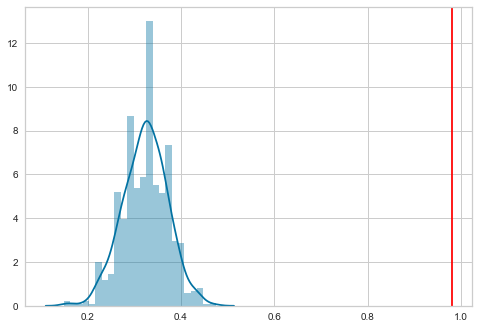

In [105]:
sns.distplot(shuffled_scores)
plt.axvline(0.98, color='red')

After target shuffling, it's blatantly obvious that our results were not random in any sense of the word.